# Description

Combining the laco datasets with the GAN model-generated sequqences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns

In [2]:
df_laco = pd.read_csv('../../Data/Zhang (DeepSEED)/ecoli_mpra_3_laco.csv')
df_laco.head()

,realA,realB,expr
0,MMMMMMMMMMMMTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,TCCCACTATTTGTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,2.346474
1,MMMMMMMMMMMMMMMMMMGTGACAAATCGTGACACAATATCGTCAC...,CTTTTTTTTGAATAAATTGTGACAAATCGTGACACAATATCGTCAC...,3.501752
2,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAMMMMMMMM...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAAACGTGTT...,5.566020
3,MMMMMMMMMMMMMACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,TCGCTCTCGGAACACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,-0.640324
4,MMMMMMMMMMMMMMMMMMMMMMMTCATAGATTAAGAATTTTCCTGA...,GCTTTAGAAACAAAAGGGACGTTTCATAGATTAAGAATTTTCCTGA...,-2.138048


In [3]:
df_results = pd.read_csv('../../Data/Zhang (DeepSEED)/inducible_ecoli_mpra_3_laco_2025-04-03-01-19-50_results.csv')
df_results.head()

,fakeB,realA,realB
0,AAAAAGAACTGTTCCCTGAGAGAGATTATTGTGATGTCATTAACGC...,MMMMMMMMMMMMTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,TCCCACTATTTGTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...
1,GTGCACGATTCTGCGACGGTAGGCACTGGTTAGACGATGTTGTGAA...,MMMMMMMMMMMMMMMMMMGTGACAAATCGTGACACAATATCGTCAC...,CTTTTTTTTGAATAAATTGTGACAAATCGTGACACAATATCGTCAC...
2,AAGGAGGGATGACTGATGCTTTCCATTGAAAAAATGCATTTCTGGA...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAMMMMMMMM...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAAACGTGTT...
3,AAACAGTTCTGATAAAGAACGTTTTCCTGAAAAAACGGCGCTGCTG...,MMMMMMMMMMMMMACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,TCGCTCTCGGAACACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...
4,AAAAGATCCCGGTGAATGCGCTTTACTGGAGGAAAAATTTTCCTGA...,MMMMMMMMMMMMMMMMMMMMMMMTCATAGATTAAGAATTTTCCTGA...,GCTTTAGAAACAAAAGGGACGTTTCATAGATTAAGAATTTTCCTGA...


In [8]:
# the number of realB (df_results) that have a corresponding realB (df_laco)
print(len(df_results[df_results['realB'].isin(df_laco['realB'])]))

# the number of realB in each df
print(len(df_results['realB'].unique()))
print(len(df_laco['realB'].unique()))


592
592
5920


In [26]:
# create a new df merging df_results and df_laco on realA and realB 
df_merged = pd.merge(df_results, df_laco, how='inner', on=['realA', 'realB'], suffixes=('_results', '_laco'))
df_merged.head()

,fakeB,realA,realB,expr
0,AAAAAGAACTGTTCCCTGAGAGAGATTATTGTGATGTCATTAACGC...,MMMMMMMMMMMMTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,TCCCACTATTTGTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,2.346474
1,GTGCACGATTCTGCGACGGTAGGCACTGGTTAGACGATGTTGTGAA...,MMMMMMMMMMMMMMMMMMGTGACAAATCGTGACACAATATCGTCAC...,CTTTTTTTTGAATAAATTGTGACAAATCGTGACACAATATCGTCAC...,3.501752
2,AAGGAGGGATGACTGATGCTTTCCATTGAAAAAATGCATTTCTGGA...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAMMMMMMMM...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAAACGTGTT...,5.566020
3,AAACAGTTCTGATAAAGAACGTTTTCCTGAAAAAACGGCGCTGCTG...,MMMMMMMMMMMMMACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,TCGCTCTCGGAACACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,-0.640324
4,AAAAGATCCCGGTGAATGCGCTTTACTGGAGGAAAAATTTTCCTGA...,MMMMMMMMMMMMMMMMMMMMMMMTCATAGATTAAGAATTTTCCTGA...,GCTTTAGAAACAAAAGGGACGTTTCATAGATTAAGAATTTTCCTGA...,-2.138048


In [27]:
# scale the real expression data

from sklearn.preprocessing import MinMaxScaler

df_merged['expr_scaled'] = MinMaxScaler().fit_transform(df_merged['expr'].values.reshape(-1, 1))

In [28]:
# load CNN model
model = keras.models.load_model('../../Models/CNN_DeepSEED_1_0.keras')

In [29]:
# Helper functions for data preprocessing
def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

def padded_one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], '0': [0, 0, 0, 0]}
    return np.array([mapping[nucleotide.upper()] for nucleotide in sequence])

In [30]:
# predict the values of fakeB and RealB using the model

df_merged['pred_fakeB'] = model.predict(preprocess_sequences(df_merged['fakeB'])).flatten()
df_merged['pred_realB'] = model.predict(preprocess_sequences(df_merged['realB'])).flatten()

df_merged.head()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,fakeB,realA,realB,expr,expr_scaled,pred_fakeB,pred_realB
0,AAAAAGAACTGTTCCCTGAGAGAGATTATTGTGATGTCATTAACGC...,MMMMMMMMMMMMTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,TCCCACTATTTGTCGGCTAGCCAGATTGTTGTGGTCTGATTAAAGT...,2.346474,0.639771,0.500843,0.590528
1,GTGCACGATTCTGCGACGGTAGGCACTGGTTAGACGATGTTGTGAA...,MMMMMMMMMMMMMMMMMMGTGACAAATCGTGACACAATATCGTCAC...,CTTTTTTTTGAATAAATTGTGACAAATCGTGACACAATATCGTCAC...,3.501752,0.728607,0.400193,0.674227
2,AAGGAGGGATGACTGATGCTTTCCATTGAAAAAATGCATTTCTGGA...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAMMMMMMMM...,GGTTCTACCGAACTTGTCATGTAAATTAAAAAAATAAAAACGTGTT...,5.566020,0.887340,0.670260,0.868708
3,AAACAGTTCTGATAAAGAACGTTTTCCTGAAAAAACGGCGCTGCTG...,MMMMMMMMMMMMMACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,TCGCTCTCGGAACACTGGCGCTTCTGCTGAAAAAAAGTCCATGGTG...,-0.640324,0.410101,0.537652,0.371744
4,AAAAGATCCCGGTGAATGCGCTTTACTGGAGGAAAAATTTTCCTGA...,MMMMMMMMMMMMMMMMMMMMMMMTCATAGATTAAGAATTTTCCTGA...,GCTTTAGAAACAAAAGGGACGTTTCATAGATTAAGAATTTTCCTGA...,-2.138048,0.294933,0.593416,0.274967


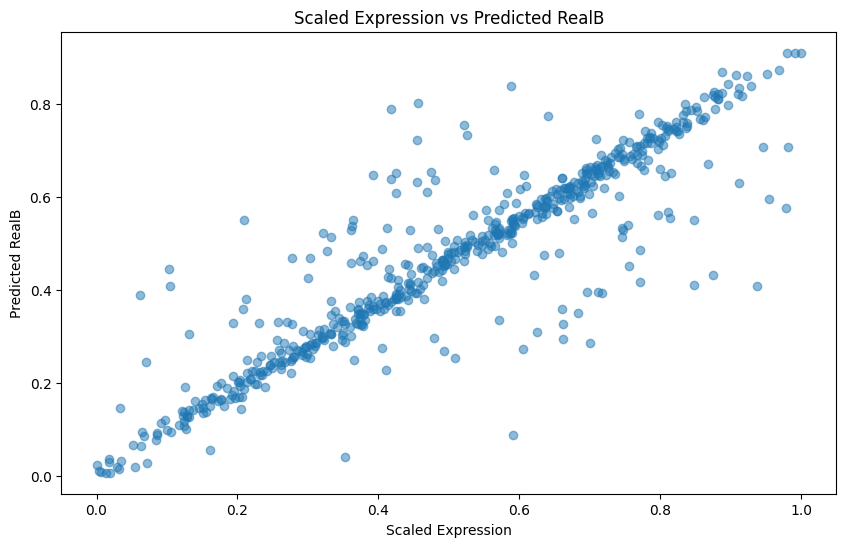

In [ ]:
# To show that the model is accurate, plot the observed expression vs predicted expression for REAL promoter sequences

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['expr_scaled'], df_merged['pred_realB'], alpha=0.5)
plt.xlabel('Observed Expression')
plt.ylabel('Predicted RealB')
plt.title('Observed Expression vs Predicted Observed Expression')
plt.show()

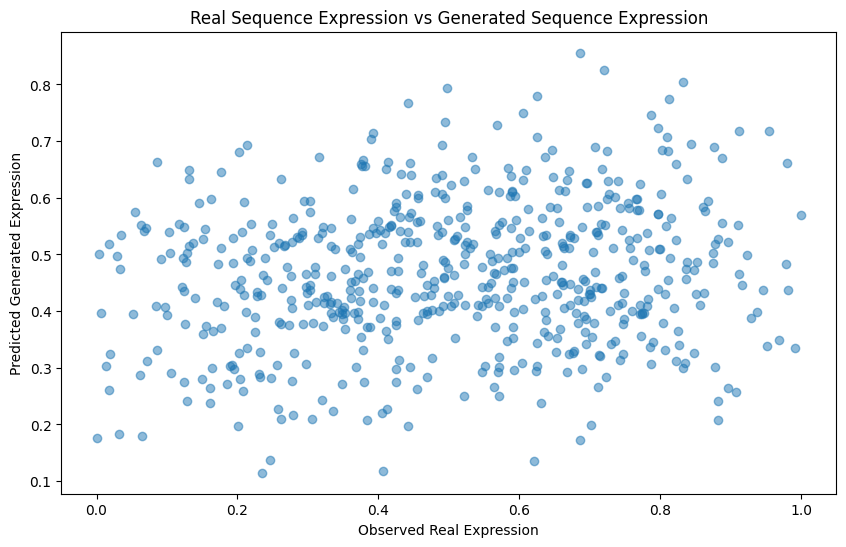

In [35]:
# Compare the real sequence expression (observed) to the generated sequence expression (predicted)

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['expr_scaled'], df_merged['pred_fakeB'], alpha=0.5)
plt.xlabel('Observed Real Expression')
plt.ylabel('Predicted Generated Expression')
plt.title('Real Sequence Expression vs Generated Sequence Expression')
plt.show()

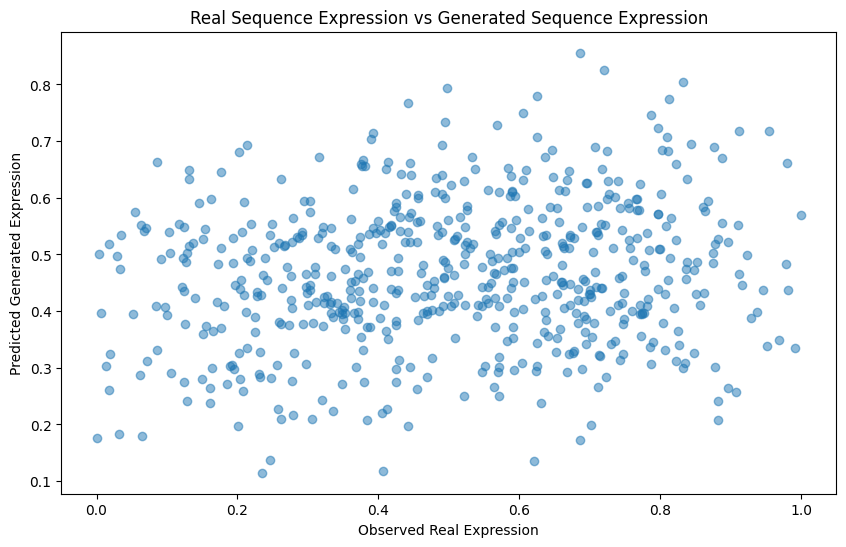

In [34]:
# Compare the real sequence expression (predicted) to the generated sequence expression (predicted)

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['expr_scaled'], df_merged['pred_fakeB'], alpha=0.5)
plt.xlabel('Observed Real Expression')
plt.ylabel('Predicted Generated Expression')
plt.title('Real Sequence Expression vs Generated Sequence Expression')
plt.show()

In [36]:
# save the merged dataframe to a csv file

df_merged.to_csv('../../Data/Zhang (DeepSEED)/inducible_ecoli_mpra_3_laco_2025-04-03-01-19-50_results_merged.csv', index=False)